Dataset: https://in.finance.yahoo.com/quote/TATAMOTORS.BO/history?p=TATAMOTORS.BO

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas import datetime
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.stats.diagnostic as diag
from sklearn.metrics import mean_squared_error

In [2]:
#Load the dataset
data = pd.read_csv('TATAMOTORS_BSE.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-16,86.750000,87.650002,82.199997,82.949997,82.949997,3827222.0
1,2020-03-17,82.699997,84.800003,77.500000,77.900002,77.900002,5206037.0
2,2020-03-18,80.000000,80.500000,75.099998,75.500000,75.500000,3815807.0
3,2020-03-19,70.599998,76.500000,68.800003,72.949997,72.949997,5387940.0
4,2020-03-20,74.300003,79.550003,72.699997,77.400002,77.400002,4843183.0


In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2021-03-09,325.299988,328.250000,309.700012,315.200012,315.200012,6082763.0
247,2021-03-10,320.000000,324.399994,316.750000,321.350006,321.350006,3898952.0
248,2021-03-12,325.899994,326.350006,314.299988,317.450012,317.450012,2103674.0
249,2021-03-15,NaN,NaN,NaN,NaN,NaN,NaN
250,2021-03-16,320.299988,321.799988,315.299988,319.750000,319.750000,1860583.0


### Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
Date         251 non-null object
Open         249 non-null float64
High         249 non-null float64
Low          249 non-null float64
Close        249 non-null float64
Adj Close    249 non-null float64
Volume       249 non-null float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


In [5]:
data.shape

(251, 7)

In [6]:
# Printing the current date and time
current_time = datetime.now()
current_time

datetime.datetime(2021, 4, 17, 2, 2, 54, 723057)

#### Our target variable will be the Close value. Hence, we will just the keep the dataset will date and target column.

In [7]:
ds = data.loc[:,['Date', 'Close']]
ds.shape

(251, 2)

### Data Cleaning

#### 1) Check for the null values in data.

In [8]:
ds.isnull().any()

Date     False
Close     True
dtype: bool

In [9]:
ds.isnull().sum()

Date     0
Close    2
dtype: int64

We will replace the null values with previous values.

In [10]:
ds.fillna(method='ffill',inplace = True)

In [11]:
ds.head()

,Date,Close
0,2020-03-16,82.949997
1,2020-03-17,77.900002
2,2020-03-18,75.500000
3,2020-03-19,72.949997
4,2020-03-20,77.400002


In [12]:
ds.tail()

,Date,Close
246,2021-03-09,315.200012
247,2021-03-10,321.350006
248,2021-03-12,317.450012
249,2021-03-15,317.450012
250,2021-03-16,319.750000


In [13]:
ds.isnull().sum()

Date     0
Close    0
dtype: int64

In [14]:
ds['Date'].dtypes

dtype('O')

In [15]:
ds.head()

,Date,Close
0,2020-03-16,82.949997
1,2020-03-17,77.900002
2,2020-03-18,75.500000
3,2020-03-19,72.949997
4,2020-03-20,77.400002


#### 2) Convert the data_timeseries['Date'] to datetime.

In [16]:
ds['Date'] = pd.to_datetime(ds['Date'])

In [17]:
ds.set_index(['Date'],inplace=True)

In [18]:
ds.head()

,Close
Date,
2020-03-16,82.949997
2020-03-17,77.900002
2020-03-18,75.500000
2020-03-19,72.949997
2020-03-20,77.400002


In [19]:
ds["Close"].count()

251

### Exploratory Data Analysis

#### Check if the data is stationary

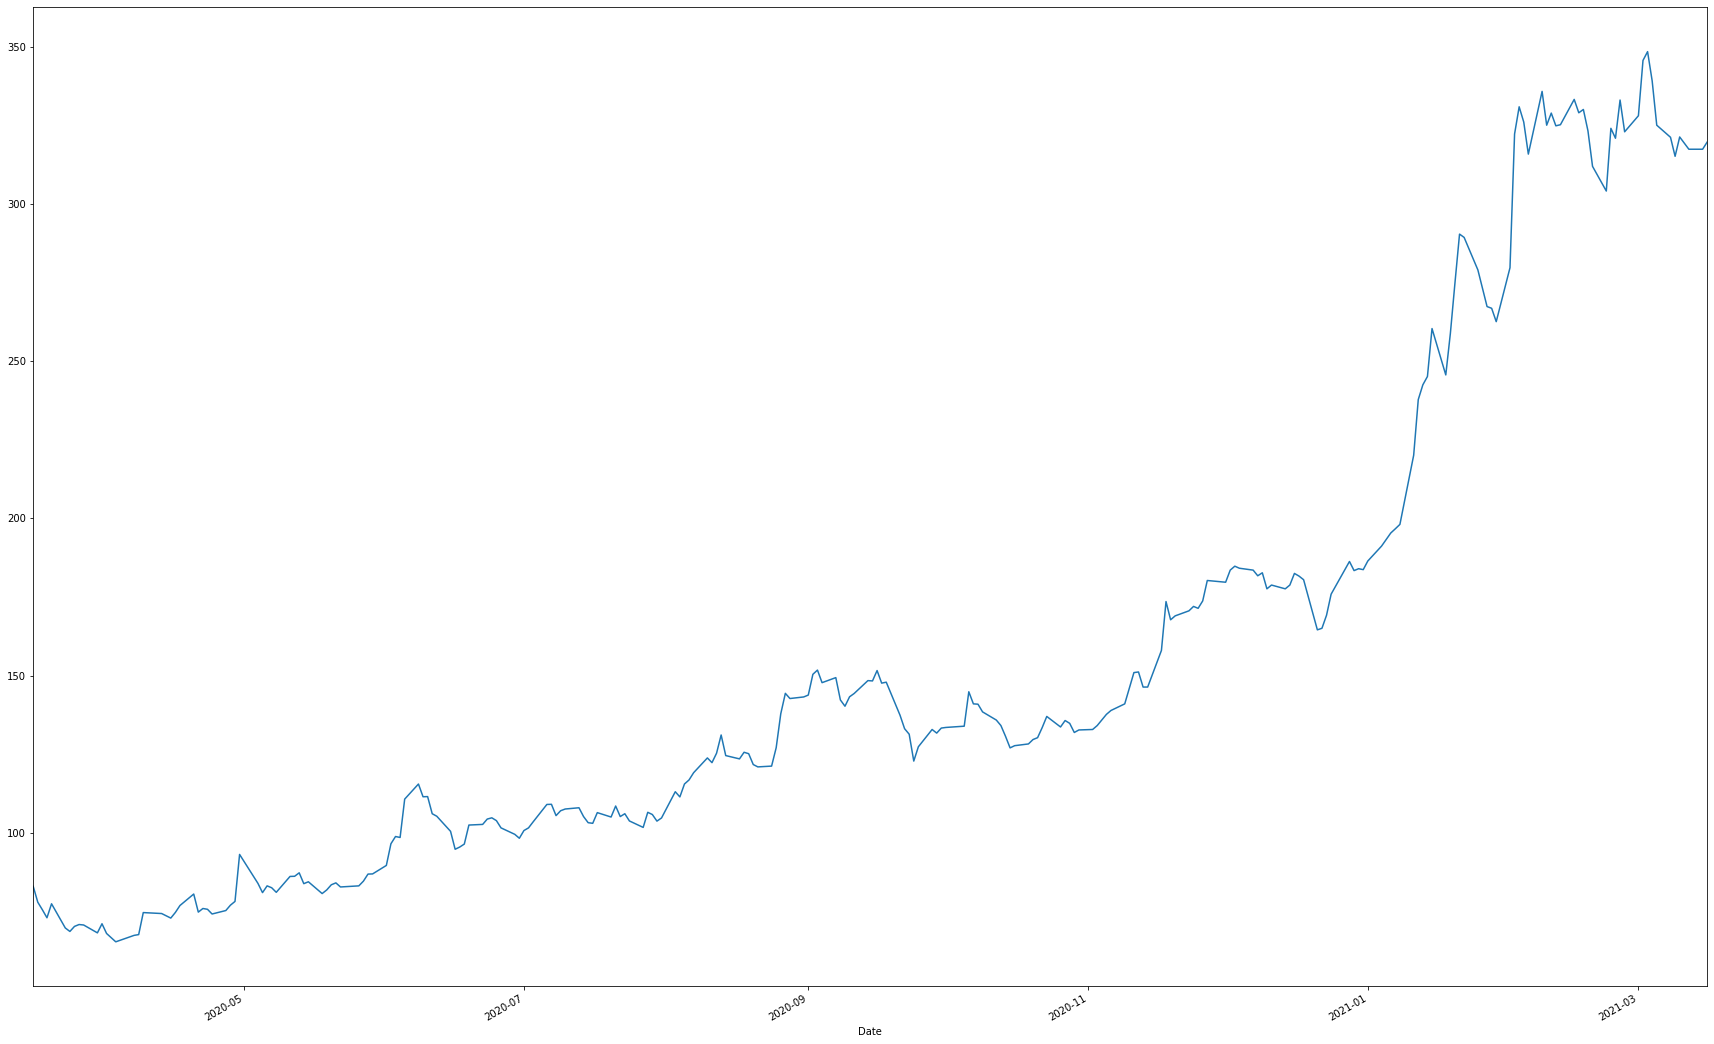

In [20]:
ds["Close"].plot(figsize=(30,20))
plt.show()

from the above graph we can see that there is a trend and seasonality in the time series. Thus, the time series is not stationary.

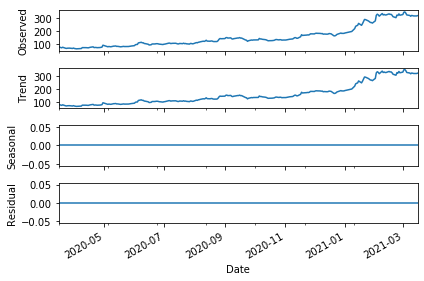

In [21]:
#Decompose the time series data into its components
result = seasonal_decompose(ds, model='additive', freq = 1)
result.plot()
plt.show()

#### Checking Stationality by Augmented Dickey-Fuller test

null hypothesis (H0) => The data has a unit root and is non-stationary.

alternate hypothesis (Ha) => The data does not have a unit root and is stationary.

In [22]:
result = adfuller(ds['Close'].values)
print(result)

(-0.18158126617569634, 0.9406817657368108, 15, 235, {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}, 1532.5951346662587)


In [23]:
print(f"ADF Statistic:{result[0]}")
print(f"p-value:{result[1]}")
print(f"critical value:")

for key, value in result[4].items():
    print(f"{key}:{value}")

ADF Statistic:-0.18158126617569634
p-value:0.9406817657368108
critical value:
1%:-3.4584868856997004
5%:-2.873918902362675
10%:-2.573367247623359


Since p-value is is greater than the critical value: 0.92>0.05, we fail to reject the null hypothesis with confidance level of 94%. Hence the data has a unit root and is non-stationary.

#### Check the randomness by Lag Plot

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random.

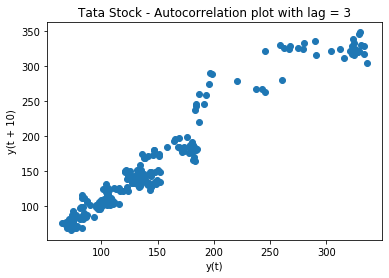

In [24]:
plt.figure()
lag_plot(ds['Close'],lag = 10)
plt.title('Tata Stock - Autocorrelation plot with lag = 3')
plt.show()

#### Check the randomness by Autocorrelation plot

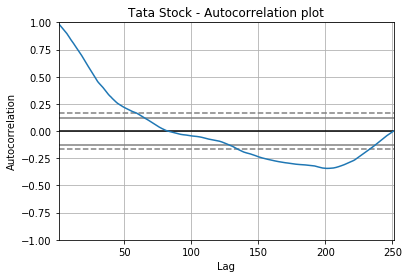

In [25]:
plt.figure()
autocorrelation_plot(ds['Close'])
plt.title('Tata Stock - Autocorrelation plot')
plt.show()

If random, autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

#### from the above plots we can conclude that the data is non-random in nature.

### Correlation and Autocorrelation

#### ACF Plot

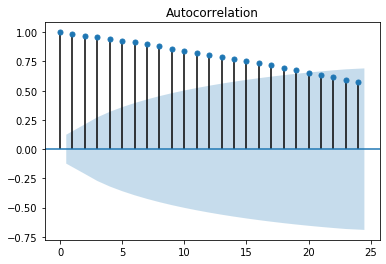

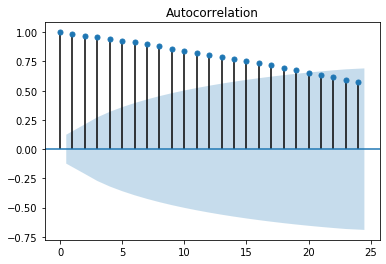

In [26]:
plot_acf(ds["Close"])

#### PACF Plot

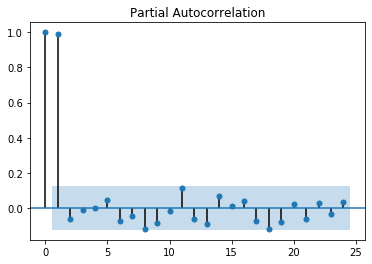

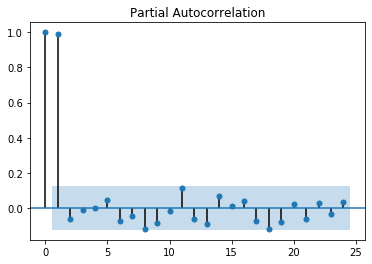

In [27]:
plot_pacf(ds["Close"])

### ARIMA Model

#### train-test split

In [28]:
len(ds)

251

In [29]:
train = ds[:124]
test = ds[124:]

In [30]:
train.shape

(124, 1)

In [31]:
test.shape

(127, 1)

####  Find the best (p,d,q) values using RMSE value

In [32]:
import itertools
import warnings
warnings.filterwarnings('ignore')

In [33]:
#Create combinations of (p,d,q)
p=range(0,8)
d=range(0,2)
q=range(0,8)

pdq_combination = list(itertools.product(p,d,q))


#Find the RMSE for each combination

rmse = []
order = []

for pdq in pdq_combination:
    try:
        model = ARIMA(train,order = pdq)
        model_fit = model.fit()
        pred = model_fit.predict(start = len(train),end =(len(ds)-1))   #prediction for test data
        error = np.sqrt(mean_squared_error(test,pred))
        order.append(pdq)
        rmse.append(error)
    
    except:
        continue

In [34]:
# Create a dataframe with order and rmse
data = {'order':order, 'rmse':rmse} 
order_rmse = pd.DataFrame(data)
order_rmse

,order,rmse
0,"(0, 0, 0)",132.222311
1,"(0, 0, 1)",132.063649
2,"(0, 1, 0)",221.524682
3,"(0, 1, 1)",221.524829
4,"(0, 1, 2)",221.523589
...,...,...
68,"(7, 1, 2)",221.450540
69,"(7, 1, 3)",221.506224
70,"(7, 1, 4)",221.507718
71,"(7, 1, 5)",221.505396


In [35]:
order_rmse['rmse'].min()

36.190651186548145

In [36]:
#find the minimum value of rmse
order_rmse[order_rmse['rmse'] == order_rmse['rmse'].min()]

,order,rmse
46,"(5, 0, 7)",36.190651


#### Fit the ARIMA model with (p,d,q) = (5, 0, 7)

In [37]:
model = ARIMA(train, order=(5, 0, 7))
model_fit = model.fit()
predict = model_fit.predict(start = len(train),end =(len(ds)-1))

In [38]:
print(model_fit.aic)

730.0005171768946


In [39]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  124
Model:                     ARMA(5, 7)   Log Likelihood                -351.000
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Apr 2021   AIC                            730.001
Time:                        02:04:51   BIC                            769.484
Sample:                             0   HQIC                           746.040
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1155.8426        nan        nan        nan         nan         nan
ar.L1.Close    -0.2163        nan        nan        nan         nan         nan
ar.L2.Close     1.2181        nan        nan    

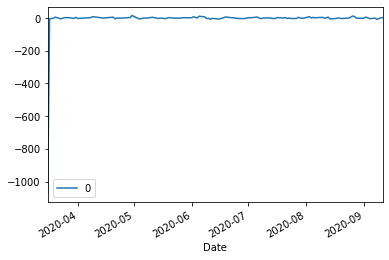

In [40]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [41]:
test_predict = test.copy()
test_predict.head()

,Close
Date,
2020-09-14,148.399994
2020-09-15,148.300003
2020-09-16,151.600006
2020-09-17,147.600006
2020-09-18,147.899994


In [42]:
test_predict['predict'] = predict.values
test_predict.head()

,Close,predict
Date,,
2020-09-14,148.399994,144.530190
2020-09-15,148.300003,145.462333
2020-09-16,151.600006,146.374451
2020-09-17,147.600006,147.542197
2020-09-18,147.899994,148.492609


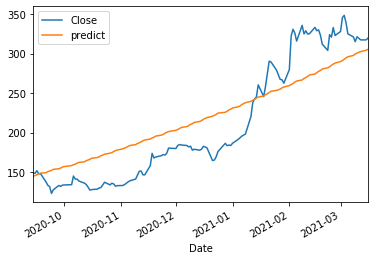

In [43]:
test_predict.plot()

#### We can see in the above graph that seasonality is removed.